# Dispersion Relations of Kane-Mele Model on Ribbon with Zigzag Boundary

In [16]:
import numpy as np
import sys
import os
from glob import glob
from copy import copy
from itertools import product
import matplotlib.pyplot as plt
plt.style.use('default')
# plt.style.use('dark_background')
%config InlineBackend.figure_format = 'svg'

In [17]:
# Pauli matrix
sx = np.array([[0,1],[1,0]], dtype=complex)
sy = np.array([[0,-1.0j],[1.0j,0]])
sz = np.diag([1, -1])

## Construct Bloch Hamiltonian

Hamiltonian basis (dimension = $4 w$)

$$
A_{0 \uparrow}, ..., A_{w-1, \uparrow}, 
A_{0 \downarrow}, ..., A_{w-1, \downarrow}, 
B_{0 \uparrow}, ..., B_{w-1, \uparrow}, 
B_{0 \downarrow}, ..., B_{w-1, \downarrow}
$$

In [18]:
def getIndex(m, a, lat, w):
    """
        Convert line number `m` and spin `a` to matrix index
        
        Parameters
        ----------
        m : int in [0, w-1]
            Line number
        a : int (0 or 1)
            Spin up (0) or down (1)
        lat : int (0 or 1)
            Sub-lattice A (0) or B (1)
        w : int > 0
            Width of the ribbon
    """
    try:
        assert m >= 0 and m < w
        assert a in [0,1]
        assert lat in [0,1]
    except AssertionError:
        print(m, a, lat, w)
        sys.exit("Assertion Error")
    return 2*w*lat + w*a + m

### Tight-binding part

$$
H_{\text{hop}} = 
-\frac{t}{N} \sum_{k, m, \alpha} \left(
\sum_l B_{k, m+\Delta_l, \alpha}^\dagger A_{k m \alpha} e^{-i k \delta_l^x} 
+ \sum_l A_{k, m-\Delta_l, \alpha}^\dagger B_{k m \alpha} e^{+i k \delta_l^x}
\right)
$$

Nearest neighbors

In [19]:
# Nearest neighbors
d1 = np.array([[0, 1/np.sqrt(3)], [1/2, -1/(2*np.sqrt(3))], [-1/2, -1/(2*np.sqrt(3))]])
# Change in line number
dw1 = [1,0,0]

In [20]:
def ham_tb(k, w, t=1):
    """Tight binding part of Hamiltonian"""
    assert isinstance(w, int) and w > 0
    ham = np.zeros((4*w, 4*w), dtype=complex)
    # hop: 0 -> A to B, 1 -> B to A
    # a: spin; m: line number
    for hop, a, m in product(range(2), range(2), range(w)):
        # determine range of summation of l
        if (hop == 0 and m == w-1) or (hop == 1 and m == 0):
            # 1. hopping from A to B
            # when m == w-1, sum over l = 2,3 only
            # 2. hopping from B to A
            # when m == 0, sum over l = 2,3 only
            lrange = [1, 2]
        else:
            lrange = range(3)
        
        for l in lrange: 
            # hopping from A to B
            # ham[m + dw1[l], a, 1; m, a, 0] += t exp(-i k d1[l,0])
            if hop == 0:
                x = getIndex(m + dw1[l], a, 1, w)
                y = getIndex(m, a, 0, w)
                ham[x,y] -= t * np.exp(-1.0j * k * d1[l,0])
            # hopping from B to A
            # ham[m - dw1[l], a, 0; m, a, 1] += t exp(+i k d1[l,0])
            elif hop == 1:
                x = getIndex(m - dw1[l], a, 0, w)
                y = getIndex(m, a, 1, w)
                ham[x,y] -= t * np.exp(1.0j * k * d1[l,0])
    # check Hermicity
    assert np.allclose(ham, np.conj(ham.T)), "Hamiltonian is not Hermitian"
    return ham

### Spin-orbit coupling part

$$
H_{\text{so}}(k) = \frac{i \lambda_{\text{so}}}{N}
\sum_{k, m, \alpha, \beta} \left(
\sum_l \nu_l e^{-i k d_l^x} A_{k,m+\Delta_l,\alpha}^\dagger s_{\alpha \beta}^z A_{k m \beta}
- \sum_l \nu_l e^{-i k d_l^x} B_{k,m+\Delta_l,\alpha}^\dagger s_{\alpha \beta}^z B_{k m \beta}
\right)
$$

Next nearest neighbors and the amplitude $\nu_{i j}$

In [21]:
d2 = np.array([[1/2, np.sqrt(3)/2], [-1/2, np.sqrt(3)/2], [-1,0],
              [-1/2, -np.sqrt(3)/2], [1/2, -np.sqrt(3)/2], [1,0]])
nu = np.asarray([(-1)**n for n in range(1,7)])
# Change in line number
dw2 = [1,1,0,-1,-1,0]

In [22]:
def ham_so(k, w, lso=0.05):
    """Spin-orbit coupling part of Hamiltonian"""
    assert isinstance(w, int) and w > 0
    ham = np.zeros((4*w, 4*w), dtype=complex)
    # lat: 0 -> A, 1 -> B
    # a, b: spin; m: line number
    for lat, a, b, m in product(range(2), range(2), range(2), range(w)):
        # determine range of summation of l
        if m == w-1:
            # upper boundary
            # when m == w-1, sum over l = 2,3,4,5 only
            lrange = [2,3,4,5]
        elif m == 0:
            # lower boundary
            # when m == 0, sum over l = 0,1,2,5 only
            lrange = [0,1,2,5]
        else:
            lrange = range(6)
            
        for l in lrange: 
            # lattice A
            # ham[m + dw2[l], a, 0; m, b, 0] += i lso nu[l] sz[a,b] exp(-i k d2[l,0])
            if lat == 0:
                x = getIndex(m + dw2[l], a, 0, w)
                y = getIndex(m, b, 0, w)
                ham[x,y] += nu[l] * sz[a,b] * np.exp(-1.0j * k * d2[l,0])
            # lattice B
            # ham[m + dw2[l], a, 1; m, b, 1] += -i lso nu[l] sz[a,b] exp(-i k d2[l,0])
            elif lat == 1:
                x = getIndex(m + dw2[l], a, 1, w)
                y = getIndex(m, b, 1, w)
                ham[x,y] -= nu[l] * sz[a,b] * np.exp(-1.0j * k * d2[l,0])
    ham *= 1.0j * lso
    # check Hermicity
    assert np.allclose(ham, np.conj(ham.T)), "Hamiltonian is not Hermitian"
    return ham

### Rashba coupling part

In [23]:
# Normalized nearest neighbor vector
d1n = d1 * np.sqrt(3)

In [24]:
def ham_R(k, w, lR=0.05):
    """Rashba coupling part of the Hamiltonian"""
    assert isinstance(w, int) and w > 0
    ham = np.zeros((4*w, 4*w), dtype=complex)
    # hop: 0 -> A to B, 1 -> B to A
    # a: spin; m: line number
    for hop, a, b, m in product(range(2), range(2), range(2), range(w)):
        # determine range of summation of l
        if (hop == 0 and m == w-1) or (hop == 1 and m == 0):
            # 1. hopping from A to B
            # when m == w-1, sum over l = 2,3 only
            # 2. hopping from B to A
            # when m == 0, sum over l = 2,3 only
            lrange = [1, 2]
        else:
            lrange = range(3)
        
        for l in lrange: 
            # hopping from A to B
            # ham[m + dw1[l], a, 1; m, b, 0] 
            # += i lR exp(-i k d1[l,0]) (sx[a,b] d1n[l,1] - sy[a,b] d1n[l,0])
            temp = sx[a,b]*d1n[l,1] - sy[a,b]*d1n[l,0]
            if hop == 0:
                x = getIndex(m + dw1[l], a, 1, w)
                y = getIndex(m, b, 0, w)
                ham[x,y] += np.exp(-1.0j * k * d1[l,0]) * temp
            # hopping from B to A
            # ham[m - dw1[l], a, 0; m, b, 1] 
            # -= i lR exp(+i k d1[l,0]) (sx[a,b] d1n[l,1] - sy[a,b] d1n[l,0])
            elif hop == 1:
                x = getIndex(m - dw1[l], a, 0, w)
                y = getIndex(m, b, 1, w)
                ham[x,y] -= np.exp(1.0j * k * d1[l,0]) * temp
    ham *= 1.0j * lR
    # check Hermicity
    assert np.allclose(ham, np.conj(ham.T)), "Hamiltonian is not Hermitian"
    return ham

### On-site potential part

In [25]:
def ham_v(k, w, lv=0.05):
    """On-site potential part of the Hamiltonian"""
    assert isinstance(w, int) and w > 0
    ham = np.zeros((4*w, 4*w), dtype=complex)
    # lat: 0 -> A, 1 -> B
    # a: spin; m: line number
    for lat, a, m in product(range(2), range(2), range(w)):
        # lattice A
        # ham[m, a, 0; m, a, 0] += lv
        if lat == 0:
            x = getIndex(m, a, 0, w)
            ham[x,x] += lv
        # lattice B
        # ham[m, a, 1; m, a, 1] -= lv
        if lat == 1:
            x = getIndex(m, a, 1, w)
            ham[x,x] -= lv
    # check Hermicity
    assert np.allclose(ham, np.conj(ham.T)), "Hamiltonian is not Hermitian"
    return ham

## Plot $E(k)$

In [26]:
def build_ham(k, w, t=1, lso=0.05, lR=0, lv=0):
    """Build full Hamiltonian of KM model on ribbon"""
    return ham_tb(k, w, t) + ham_so(k, w, lso) + ham_R(k, w, lR) + ham_v(k, w, lv)

Since we set the next nearest neighbor distance to 1, the plot range of $k \equiv k_x$ is $[0, 2\pi]$

In [27]:
3*np.sqrt(3)*0.1

0.5196152422706632

In [28]:
xdata = np.linspace(0, 2*np.pi, num=200)
param = dict(w=20, t=1, lso=0, lR=0, lv=0)
Edata = []
for k in xdata:
    Edata.append(np.linalg.eigvalsh(build_ham(k, **param)))
Edata = np.asarray(Edata)

In [29]:
Edata.shape

(200, 80)

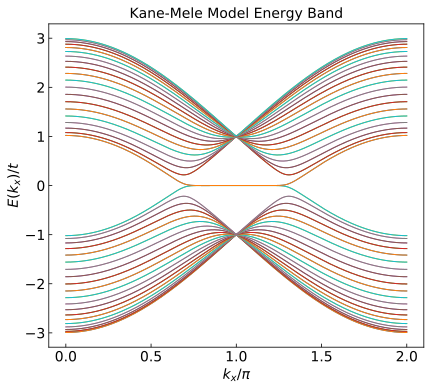

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# fig.patch.set_facecolor('#000000')
# adjust spacing
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.97, top=0.9, 
                    wspace=0.3, hspace=0.4)
ax.set_title(r"Kane-Mele Model Energy Band", fontsize=14)
ax.set_xlabel(r"$k_x/\pi$", fontsize=14)
ax.set_ylabel(r"$E(k_x)/t$", fontsize=14)
tickpt = np.around(np.arange(0, 2.1, 0.5), decimals=1)
ax.set_xticks(tickpt * np.pi)
ptname = [str(pt) for pt in tickpt]
ax.set_xticklabels(ptname)
ax.tick_params(axis='both', direction='in', labelsize=14)

for band in range(Edata.shape[1]):
    ydata = Edata[:, band]
    ax.plot(xdata, ydata, linewidth=1)
    
# ax.axvline(x=2*np.pi/3, color='green', linestyle=':')
# ax.axvline(x=4*np.pi/3, color='green', linestyle=':')